In [1]:
import pandas as pd
import numpy as np
import ssl
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [2]:
symbol = 'BTCUSDT'
filepath = f"https://www.cryptodatadownload.com/cdd/Binance_{symbol}_d.csv"  
ssl._create_default_https_context = ssl._create_unverified_context

df = pd.read_csv(filepath, skiprows=1)
df.head() 

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.640995e+12,2022-01-01 00:00:00,BTC/USDT,46216.93,46527.26,46208.37,46332.51,386.43504,1.791172e+07,11081.0
1,1.640909e+12,2021-12-31 00:00:00,BTC/USDT,47120.88,48548.26,45678.00,46216.93,34937.99796,1.650716e+09,1059783.0
2,1.640822e+12,2021-12-30 00:00:00,BTC/USDT,46464.66,47900.00,45900.00,47120.87,30352.29569,1.428756e+09,910157.0
3,1.640736e+12,2021-12-29 00:00:00,BTC/USDT,47543.74,48139.08,46096.99,46464.66,39498.87000,1.873786e+09,1114074.0
4,1.640650e+12,2021-12-28 00:00:00,BTC/USDT,50701.44,50704.05,47313.01,47543.74,45853.33924,2.242102e+09,1345774.0


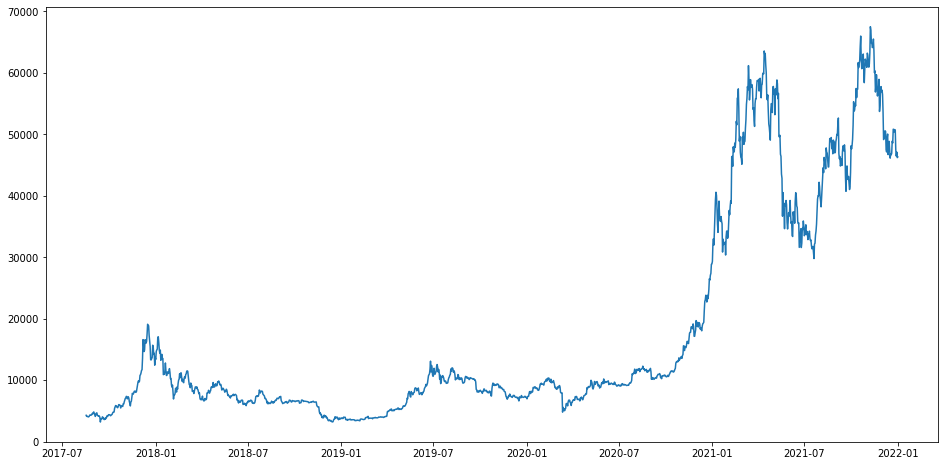

In [3]:
#setting index as date
df['date'] = pd.to_datetime(df.date,format='%Y-%m-%d')
df.index = df['date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['close'], label='Close Price history')

In [4]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df))
                        ,columns=['date', 'close'])
for i in range(0,len(data)):
    new_data['date'][i] = data['date'][i]
    new_data['close'][i] = data['close'][i]

#setting index
new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)    

In [5]:
#creating train and test sets
dataset = new_data.values

train = dataset[0:1000,:]
valid = dataset[1000:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset) 

In [6]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [7]:
x_train.shape

(940, 60, 1)

In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,
               input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(x_train, y_train, epochs=3, batch_size=1, verbose=1)

Epoch 1/3
940/940 [==============================] - 45s 42ms/step - loss: 2.6928e-04
Epoch 2/3
940/940 [==============================] - 28s 29ms/step - loss: 1.3434e-04
Epoch 3/3
940/940 [==============================] - 28s 30ms/step - loss: 1.0227e-04


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


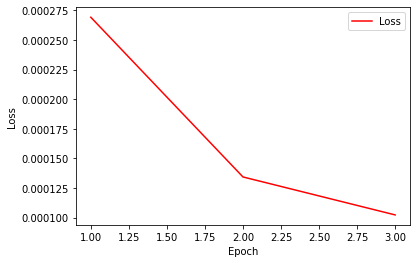

In [11]:
plt.plot(np.array([1, 2, 3]), history.history['loss'], color='r', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


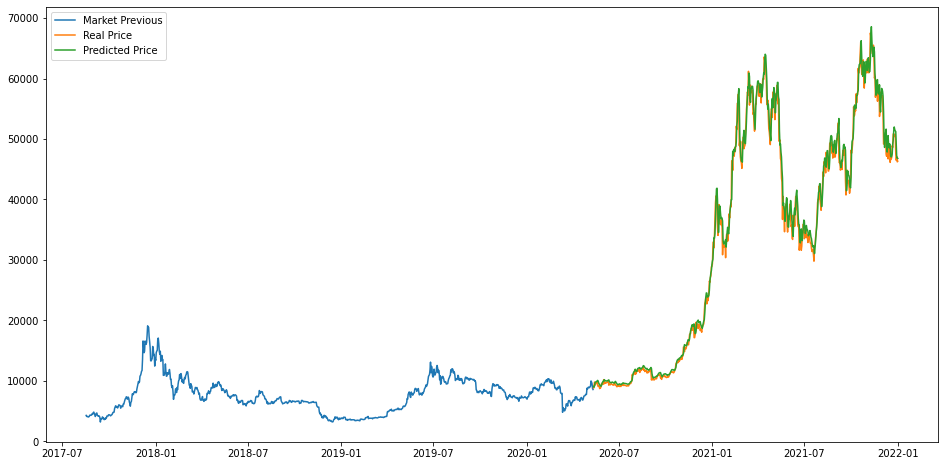

In [13]:
#for plotting
plt.figure(figsize=(16,8))
train = new_data[:1000]
valid = new_data[1000:]
valid['Predictions'] = closing_price
plt.plot(train['close'], label='Market Previous' )
plt.plot(valid['close'], label='Real Price' )
plt.plot(valid['Predictions'], label='Predicted Price' )
plt.legend()
plt.show()

In [14]:
def PredictTodayClose():
  Last60DaysPrices = new_data.values
  Last60DaysPrices = Last60DaysPrices[Last60DaysPrices.shape[0]-61:-1]
  Last60DaysPrices = Last60DaysPrices.reshape(-1,1)
  Last60DaysPrices = scaler.transform(Last60DaysPrices)
  Last60DaysPrices = np.reshape(Last60DaysPrices, (1,Last60DaysPrices.shape[0], 1))
  predicted = model.predict(Last60DaysPrices)
  predicted = scaler.inverse_transform(predicted)
  return predicted[0][0]

In [15]:
print(f"My Prediction For Today's BTC Close Price is : {PredictTodayClose()} USDT")

My Prediction For Today's BTC Close Price is : 46789.9296875 USDT
